In [1]:
import numpy as np
import glob
import tensorflow as tf
from numpy.lib.stride_tricks import as_strided
import sys
import matplotlib.pyplot as plt
import time
import os
import re
G = 6.67408e-11
c = 2.99792458e8
M_SUN = 2.0e30

2023-07-13 12:10:10.400899: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [5]:
time_start = time.time()
#dat_file = sys.argv[1]
#output_label = sys.argv[2]
dat_file = '/hercules/scratch/vishnu/ABHNINAV_ML_PROJECT/PulsarNet/OBS1_dedisp_ts_part2.dat'
#dat_file = '/hercules/results/atya/BinaryML/sims/runBC/obs4BC.dat'
output_label = 'obs1'
dat = np.fromfile(dat_file, dtype=np.float32)
dat = (dat - np.mean(dat)) / np.std(dat)
fft = np.fft.rfft(dat)
power = np.abs(fft)**2
power = (power - np.mean(power))/np.std(power)

In [3]:
fft_size = len(dat)
time_res = 64e-6 # in seconds
T_obs = (fft_size*time_res)/60 # in minutes is equal to 17.895 minutes
freq_axis = np.fft.rfftfreq(fft_size, d=time_res)
freq_res = 1/(T_obs*60)

In [4]:
p =  0.02150015
f = 1/p
#f=900
f_ind = f/freq_res

In [6]:
chunk = power[int(f_ind-400):int(f_ind+400)]


In [18]:
import numpy as np
from scipy.interpolate import interp1d

# Generate a sample spectrum
spectrum = fft[int(f_ind-400):int(f_ind+400)]

# Define the desired number of interpolated points
interpolated_points = 800000

# Create a frequency axis corresponding to the original spectrum
frequency_axis = freq_axis[int(f_ind-400):int(f_ind+400)]

# Create an interpolation function for the spectrum
interpolated_spectrum = interp1d(frequency_axis, spectrum)

# Interpolate the spectrum at desired frequency points
interpolated_spectrum_values = interpolated_spectrum(np.linspace(frequency_axis.min(), frequency_axis.max(), interpolated_points))


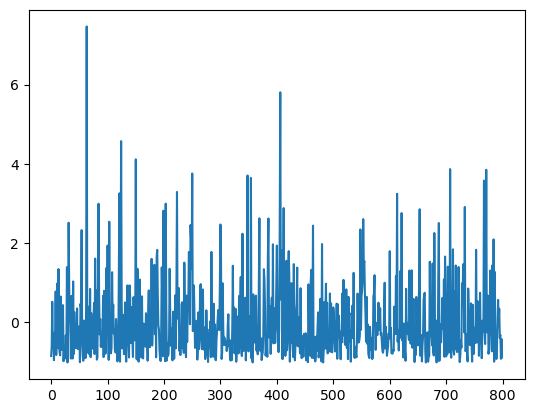

In [20]:
power_spectrum = np.abs(spectrum)**2
power_spectrum_norm = (power_spectrum - np.mean(power_spectrum))/np.std(power_spectrum)
plt.plot(power_spectrum_norm)

In [21]:
power_interpolated_spectrum_values = np.abs(interpolated_spectrum_values)**2
power_spectrum_norm = (power_interpolated_spectrum_values - np.mean(power_interpolated_spectrum_values))/np.std(power_interpolated_spectrum_values)

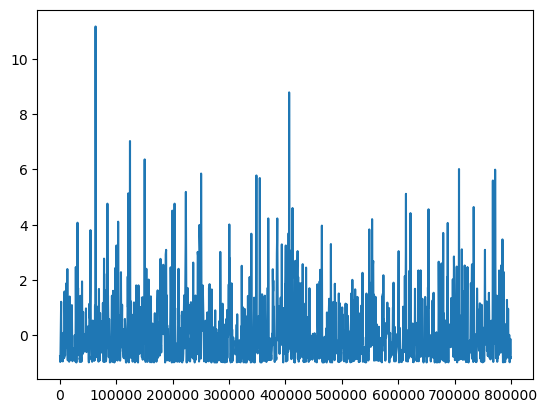

In [22]:
plt.plot(power_interpolated_spectrum_values_norm)

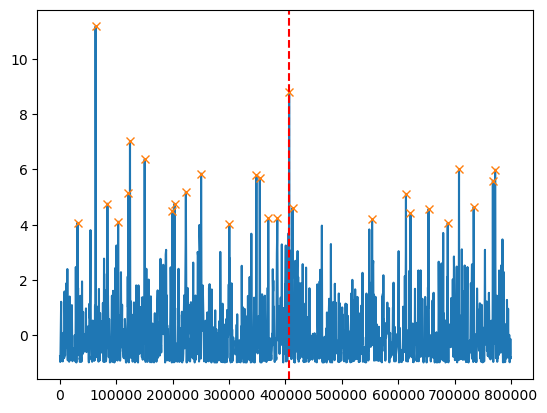

In [25]:
# scipy find peaks
from scipy.signal import find_peaks
peaks, _ = find_peaks(power_interpolated_spectrum_values_norm, height=4)
plt.plot(power_interpolated_spectrum_values_norm)
plt.plot(peaks, power_interpolated_spectrum_values_norm[peaks], "x")
plt.axvline(x=peaks[16], color='r', linestyle='--')
plt.show()

In [29]:
p = interpolated_spectrum_values
print((np.abs(p[peaks[16]-1] + p[peaks[16]])**2)/2,np.abs(p[peaks[16]])**2,(np.abs(p[peaks[16]] + p[peaks[16]+1])**2)/2)

233298806.88009834 116724933.23791356 233232707.05926248


In [30]:
print(np.abs(p[peaks[3]-1] + p[peaks[3]])**2/2,np.abs(p[peaks[3]])**2,np.abs(p[peaks[3]] + p[peaks[3]+1])**2/2)

121626477.4151916 60846370.863119766 121610518.03254995


In [ ]:
print((np.abs(p[peaks[16]-1] + p[peaks[16]])**2)/2,np.abs(p[peaks[16]])**2,(np.abs(p[peaks[16]] + p[peaks[16]+1])**2)/2)

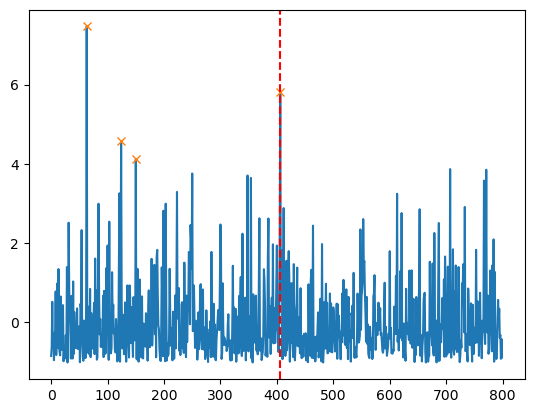

In [32]:
# scipy find peaks
from scipy.signal import find_peaks
peaks, _ = find_peaks(power_spectrum_norm, height=4)
plt.plot(power_spectrum_norm)
plt.plot(peaks, power_spectrum_norm[peaks], "x")
plt.axvline(x=peaks[3], color='r', linestyle='--')
plt.show()

In [38]:
p = spectrum
peak_num = 3
middle = np.abs(p[peaks[peak_num]])**2
print(middle,middle/((np.abs(p[peaks[peak_num]-1] + p[peaks[peak_num]])**2)/2),middle/((np.abs(p[peaks[peak_num]] + p[peaks[peak_num]+1])**2)/2))

116805967.93792784 6.565978743907231 1.4596162965780715


In [37]:
p = spectrum
peak_num = 0
middle = np.abs(p[peaks[peak_num]])**2
print(middle,middle/((np.abs(p[peaks[peak_num]-1] + p[peaks[peak_num]])**2)/2),middle/((np.abs(p[peaks[peak_num]] + p[peaks[peak_num]+1])**2)/2))

145262862.6926541 4.397204347543686 1.4234836817376957


In [8]:
f = 46.35
f_ind2 = f/freq_res

In [9]:
f

46.35

In [10]:
f_ind2

5076329.2213248005

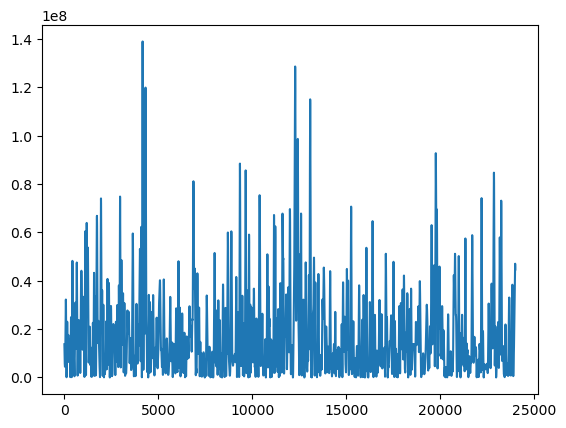

In [18]:
plt.plot(power[int(f_ind-12000):int(f_ind+12000)])

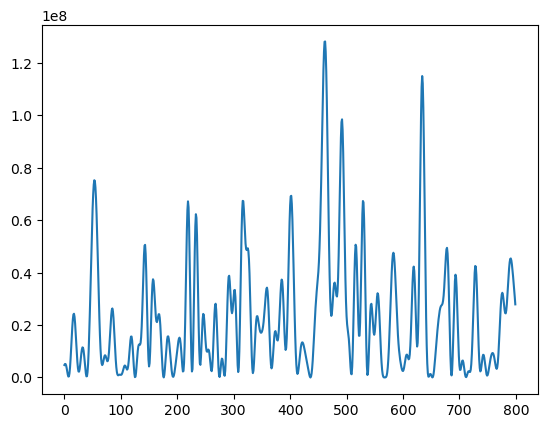

In [10]:
plt.plot(power[int(f_ind-400):int(f_ind+400)])

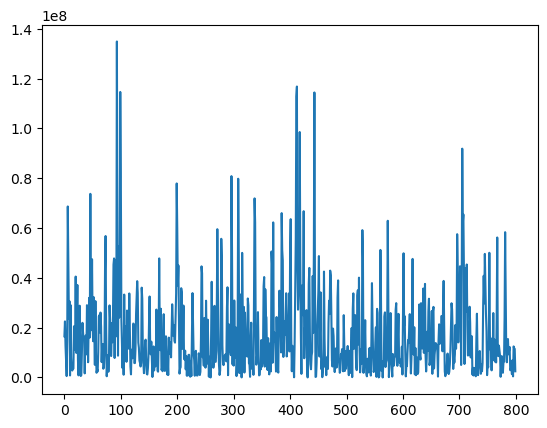

In [44]:
plt.plot(power[int(f_ind-400):int(f_ind+400)])

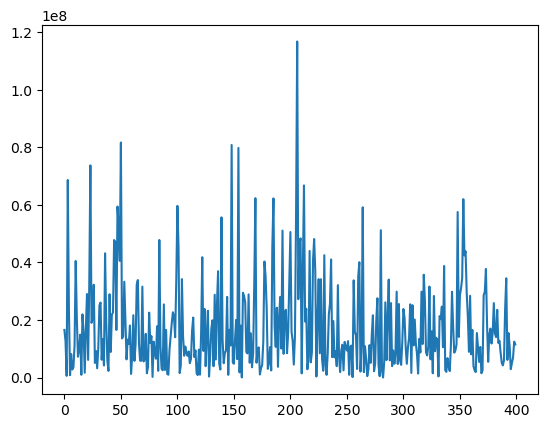

In [8]:
plt.plot(power[int(f_ind-200):int(f_ind+200)])

In [30]:
snr_predict = tf.keras.models.load_model('models/snr_predict_attention_1567308_checkpoint.h5')

In [7]:
classifier = tf.keras.models.load_model("models/chunk_classify_attention_2528257_checkpoint.h5")

2023-07-13 12:13:00.083137: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-07-13 12:13:00.084363: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-07-13 12:13:00.593043: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-07-13 12:13:00.593138: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hercules11): /proc/driver/nvidia/version does not exist
2023-07-13 12:13:00.594914: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler

In [8]:
#chunk = power[int(f_ind-400):int(f_ind+400)]
#chunk_norm = (chunk - np.mean(chunk))/np.std(chunk)
chunk_norm = chunk/np.max(chunk)

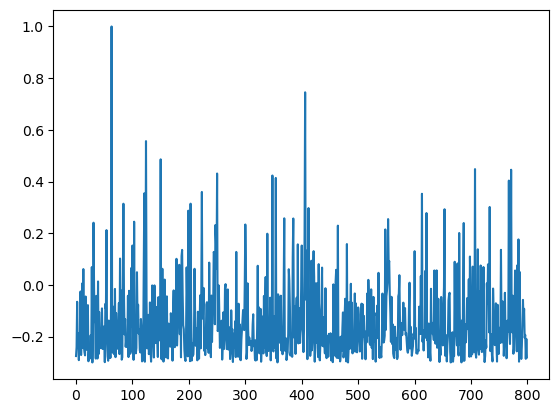

In [9]:
plt.plot(chunk_norm)

In [11]:
classifier.predict(chunk_norm.reshape(1,800,1))

array([[0.99086106, 0.00913898]], dtype=float32)

In [13]:
snr_predict.predict(chunk_norm.reshape(1,400,1))/100

NameError: name 'snr_predict' is not defined

In [15]:
(model_classifier.predict(chunk_norm.reshape(1,800,1)))

2023-07-05 15:19:58.580967: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-07-05 15:19:58.581436: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400000000 Hz


array([[9.0123153e-01, 9.8600060e-02, 1.4811616e-07, 1.6828615e-04]],
      dtype=float32)

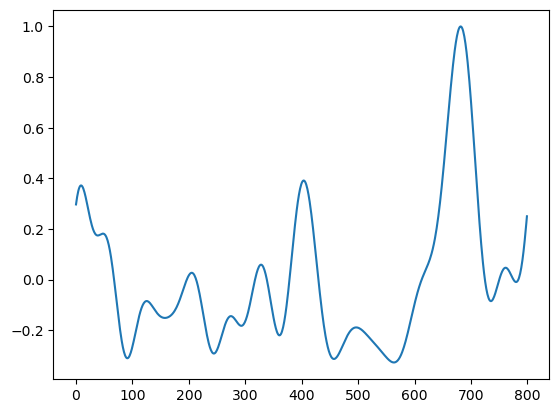

In [16]:
plt.plot(chunk_norm)

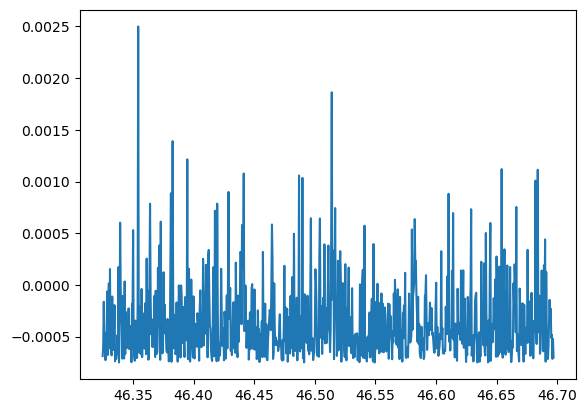

In [17]:
plt.plot(freq_axis[int(f_ind-400):int(f_ind+400)],power[int(f_ind-400):int(f_ind+400)])

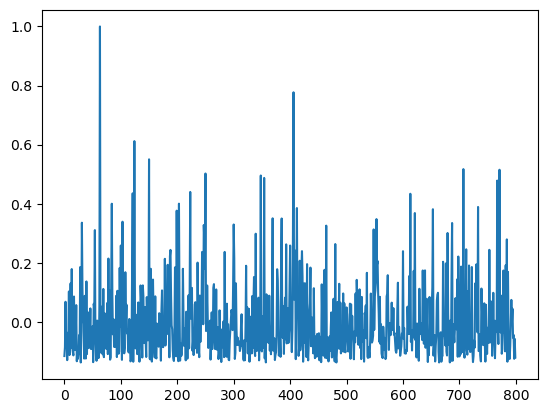

In [26]:
plt.plot(chunk_norm)

In [4]:
fft_size = len(dat)
time_res = 64e-6 # in seconds
T_obs = (fft_size*time_res)/60 # in minutes is equal to 17.895 minutes
freq_axis = np.fft.rfftfreq(fft_size, d=time_res)
freq_res = 1/(T_obs*60)

In [14]:
chunk_size = 800
freq_start = 40  # in Hz 
freq_end = 1000 # in Hz
freq_ind_start = np.argmin(np.abs(freq_axis - freq_start)) - chunk_size
freq_ind_end = np.argmin(np.abs(freq_axis - freq_end)) + chunk_size

#model_classifier = tf.keras.models.load_model('models/chunk_classify_cnn_1533007_checkpoint.h5')
model_regressor_z = tf.keras.models.load_model('models/low_snr_f_predict_attention_1533111_checkpoint.h5')
model_regressor_f = tf.keras.models.load_model('models/low_snr_f_predict_cnn_1532811_checkpoint.h5')
model_classifier = tf.keras.models.load_model('models/chunk_classify_cnn_1259068_model.h5')
#model_regressor_f = tf.keras.models.load_model('models/f_predict_cnn_1280525_model.h5')
#model_regressor_z = tf.keras.models.load_model('models/f_predict_attention_z_fine_1231538_55_model.h5')


2023-07-05 15:19:20.006578: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-07-05 15:19:20.007709: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-07-05 15:19:20.817150: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-07-05 15:19:20.817227: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hercules11): /proc/driver/nvidia/version does not exist
2023-07-05 15:19:20.818736: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler

In [5]:
def find_correct_chunk(freq_ind_start,chunk_abs_loc,relative_loc_signal_in_chunk,step_size,roll_offset_begin,chunk_buffer_on_either_side,chunk_size):
    chunk_refactored_start = (chunk_abs_loc - chunk_buffer_on_either_side) if (chunk_abs_loc - chunk_buffer_on_either_side) >= 0 else 0
    return freq_ind_start + (chunk_refactored_start*chunk_size) + (relative_loc_signal_in_chunk)*step_size + step_size + roll_offset_begin

def find_location(arr):
    result = np.argwhere(np.isin(arr, [1, 2, 3]))
    return np.sort(result)

def find_first_one(arr):
    result = np.where(arr == 1)
    if len(result[0]) > 0:
        return np.sort(result)[0][0]
    else:
        return -1

def a_from_z(z,T_obs,h,P_s):
    T_obs = T_obs*3600
    return z*P_s*c/(T_obs**2*h)

def a_to_pdot(P_s, acc_ms2):
    return P_s * acc_ms2 /c

def calculate_presto_fold_p_neg(p,pd,T_obs):
    '''
    p: period in seconds
    pd: period derivative in seconds/second
    T_obs: observation time in hours
    '''
    T_obs = T_obs*3600
    return p - pd*T_obs/2  

def myexecute(cmd):
    if 'echo' not in cmd[:20]:
        os.system("echo '%s'"%cmd)
    os.system(cmd)

In [6]:
num_chunks = int((freq_ind_end - freq_ind_start)/chunk_size)
X_test_freq = power[freq_ind_start:freq_ind_end]
X_test_freq_chunks = X_test_freq[:int(num_chunks*chunk_size)].reshape((num_chunks,chunk_size,1))
X_test_freq_chunks_norm = X_test_freq_chunks/np.max(X_test_freq_chunks,axis=1)[:,None]

num_chunks_in_group = 100
num_groups = int(num_chunks/num_chunks_in_group)
step_size = chunk_size // 2
chunk_buffer_on_either_side = 3
num_windows_when_overlapped = ((2*chunk_buffer_on_either_side*chunk_size) - chunk_size) // step_size + 1
signal_indices_pattern_str = ''.join(map(str, [0,1,1,0]))
current_group_index = 0
roll_list_in_either_direction = [0,300,200,100]
signal_chunk_found = False

In [7]:
found_signals = []
while not signal_chunk_found and current_group_index < num_groups:
    chunk_group_start = current_group_index*num_chunks_in_group
    chunk_group_end = (current_group_index+1)*num_chunks_in_group if ((current_group_index+1)*num_chunks_in_group < num_chunks) else num_chunks
    X_test_freq_group_of_chunks = X_test_freq_chunks_norm[chunk_group_start:chunk_group_end]
    labels_temp = model_classifier.predict(X_test_freq_group_of_chunks)
    labels_max = np.argmax(labels_temp,axis=1)
    print(labels_max)
    loc_list = find_location(labels_max)
    print('loc_list',loc_list)
    last_loc_signal = -2
    for loc_index in range(len(loc_list)):
        signal_dict = {}
        current_loc_signal = loc_list[loc_index][0]
        #print(current_loc_signal - last_loc_signal)
        if ( current_loc_signal - last_loc_signal) > 1:
            loc_chunk_with_signal = num_chunks_in_group*current_group_index + current_loc_signal
            print('loc_chunk_with_signal',loc_chunk_with_signal)
            if not signal_chunk_found: #If the signal is detected
                chunk_abs_loc = loc_chunk_with_signal
                chunk_refactored_start = (chunk_abs_loc - chunk_buffer_on_either_side) if (chunk_abs_loc - chunk_buffer_on_either_side) >= 0 else 0
                chunk_refactored_end = (chunk_abs_loc + chunk_buffer_on_either_side) if (chunk_abs_loc + chunk_buffer_on_either_side) <= num_chunks else num_chunks
                print('chunk_refactored_difference',chunk_refactored_start-chunk_refactored_end)
                if chunk_refactored_start == 0:
                    chunk_refactored_end = 2*chunk_buffer_on_either_side
                if chunk_refactored_end == num_chunks:
                    chunk_refactored_start = num_chunks - (2*chunk_buffer_on_either_side)
                print('chunk_refactored_Start',chunk_refactored_start)
                print('chunk_refactored_end',chunk_refactored_end)
                X_test_chunks_temp_flattened = X_test_freq_chunks[int(chunk_refactored_start):int(chunk_refactored_end)].flatten()
                for roll_number in roll_list_in_either_direction:
                    if not signal_chunk_found:
                        for roll_number_case in ['pos','neg']:
                            if roll_number == 0 and roll_number_case == 'neg':
                                continue
                            else:
                                roll_offset_begin = roll_number if roll_number_case == 'pos' else (chunk_size - roll_number)
                                roll_offset_end = roll_number - chunk_size if roll_number_case == 'pos' else -roll_number
                                print('roll_offset',roll_offset_begin,roll_offset_end)
                                X_test_chunks_temp_overlapped = as_strided(
                                    X_test_chunks_temp_flattened[roll_offset_begin:roll_offset_end],
                                    shape = (num_windows_when_overlapped-1,chunk_size),
                                    strides = (step_size * X_test_chunks_temp_flattened.strides[0],X_test_chunks_temp_flattened.strides[0]))
                        
                                X_test_chunks_temp_overlapped_norm = (X_test_chunks_temp_overlapped/np.max(X_test_chunks_temp_overlapped,axis=1)[:,None]).reshape(num_windows_when_overlapped-1,chunk_size,1)
                                print(X_test_chunks_temp_overlapped_norm.shape)
                                labels_new = model_classifier.predict(X_test_chunks_temp_overlapped_norm)
                                labels_new_max = np.argmax(labels_new,axis=1)
                                labels_new_max_str = ''.join(map(str, labels_new_max.tolist()))
                                
                                print(roll_number,roll_number_case,labels_new_max_str)
                                if signal_indices_pattern_str in labels_new_max_str:
                                    relative_loc_signal_in_chunk = find_first_one(labels_new_max)
                                    print('relative_loc_Signal',relative_loc_signal_in_chunk)
                                    if relative_loc_signal_in_chunk == -1:
                                        print("Error in relative loc signal in chunk")
                                        continue
                                    else:
                                        regressor_chunk_start = find_correct_chunk(freq_ind_start,
                                                chunk_abs_loc,
                                                relative_loc_signal_in_chunk,
                                                step_size,
                                                roll_offset_begin,
                                                chunk_buffer_on_either_side,
                                                chunk_size)
                                        regressor_chunk_end = regressor_chunk_start + step_size
                                        final_chunk = power[int(regressor_chunk_start):int(regressor_chunk_end)]
                                        final_chunk = final_chunk/np.max(final_chunk)
                                        f = model_regressor_f(final_chunk.reshape((1,400,1)).astype(np.float64)).numpy()[0][0]
                                        z = model_regressor_z(final_chunk.reshape((1,400,1)).astype(np.float64)).numpy()[0][0]/2
                                        print(f,z)
                                        if (f + z) < step_size:
                                            signal_dict['f_ind'] = f + regressor_chunk_start
                                            signal_dict['z'] = z 
                                            signal_dict['regressor_chunk_start'] = regressor_chunk_start
                                        
                                            found_signals.append(signal_dict.copy())
                                        
                                        
                                            signal_chunk_found = True
                                            break
                    else:
                        last_loc_signal = current_loc_signal
                        break

            if not signal_chunk_found:
                print('False alarm in this group. Moving to the next group')
    current_group_index += 1

2023-06-30 15:54:58.676727: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-06-30 15:54:58.677226: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400000000 Hz


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
loc_list []
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
loc_list []
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
loc_list [[96]]
loc_chunk_with_signal 296
chunk_refactored_difference -6
chunk_refactored_Start 293
chunk_refactored_end 299
roll_offset 0 -800
(10, 800, 1)
0 pos 0000011000
relative_loc_Signal 5
198.82935 46.49119567871094


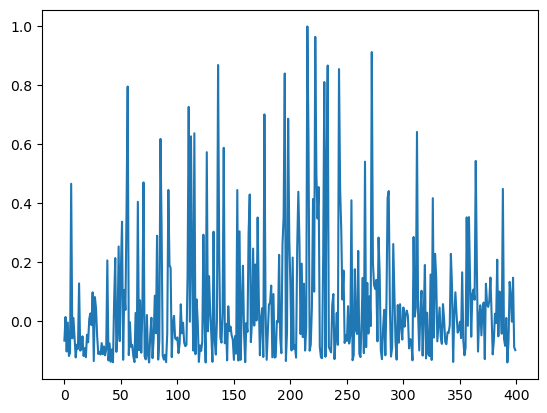

In [8]:
plt.plot(final_chunk)

0.006667178268050778


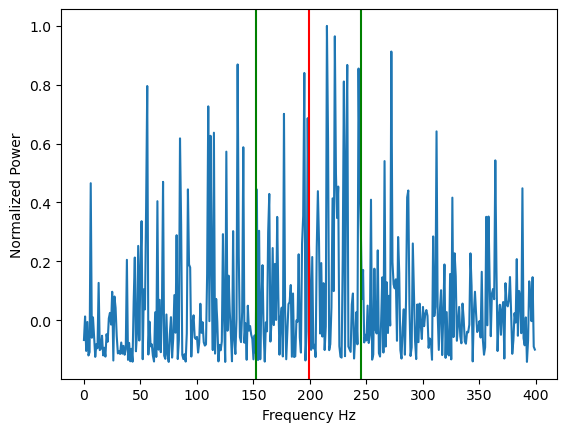

In [9]:
regressor_chunk_start = found_signals[0]['regressor_chunk_start']
f_ind = found_signals[0]['f_ind']
z = found_signals[0]['z']
regressor_chunk_end = regressor_chunk_start + step_size
final_chunk = power[int(regressor_chunk_start):int(regressor_chunk_end)]
final_chunk = final_chunk/np.max(final_chunk)
p_pred = 1/(f_ind*freq_res)
a_pred_abs = a_from_z(z,T_obs/60,1,p_pred)
pd_pred_abs = a_to_pdot(p_pred,a_pred_abs)
p_fold_pos_z = calculate_presto_fold_p_neg(p_pred,pd_pred_abs,T_obs/60)
p_fold_neg_z = calculate_presto_fold_p_neg(p_pred,-pd_pred_abs,T_obs/60)
print(p_pred)

# sing_prefix = 'singularity exec -H $HOME:/home1 -B /hercules:/hercules/  /hercules/scratch/atya/compare_pulsar_search_algorithms.simg '
# myexecute(sing_prefix+f'prepfold -topo -p {p_fold_pos_z} -pd {pd_pred_abs} -o {output_label}_pos -noxwin {dat_file}')
# myexecute(sing_prefix+f'prepfold -topo -p {p_fold_neg_z} -pd {-pd_pred_abs} -o {output_label}_neg -noxwin {dat_file}')

# files_list_temp = glob.glob(f'{output_label}*pfd.bestprof')
# sigma_levels = []

# for i in range(len(files_list_temp)):
#     file_name_temp = files_list_temp[i]
#     with open(file_name_temp, 'r') as file:
#         lines = file.readlines()
#         line = lines[13]  # Since we count from 0, the 10th line is at index 9
#         match = re.search(r'~(\d+.\d+) sigma', line)
#         if match:
#             sigma_levels.append(float(match.group(1)))

# pos_or_neg_ind = np.argmax(sigma_levels)
# if 'pos' in files_list_temp[pos_or_neg_ind]:
#     pos_or_neg = 'pos'
# else:
#     pos_or_neg = 'neg'

# #write values in a text file
# with open(f'{output_label}_predictions.txt','w') as file:
#     file.write(f'predicted_p_middle[ms]: {p_pred*1000:.10f}\n')
#     file.write(f'predicted_a_magnitude[m/s^2]: {a_pred_abs:.5f}\n')
#     file.write(f'predicted_pdot_magnitude[s/s]: {format(pd_pred_abs, "e")}\n')
#     file.write(f'predicted_p_fold_pos_z[ms]: {p_fold_pos_z*1000:.10f}\n')
#     file.write(f'predicted_p_fold_neg_z[ms]: {p_fold_neg_z*1000:.10f}\n')
#     file.write(f'predicted_sigma_levels: {sigma_levels}\n')
#     file.write(f'predicted_pos_or_neg_accel_sign: {pos_or_neg}\n')
#     file.write(f'predicted_f[index]: {f}\n')
#     file.write(f'predicted_z[index]: {z}\n')
#     file.write(f'time_taken[s]: {time.time() - time_start:.5f}\n')

plt.plot(final_chunk)
plt.xlabel('Frequency Hz')
plt.ylabel('Normalized Power')
plt.axvline(f, color='r')
plt.axvline(f + z, color='g')
plt.axvline(f - z, color='g')
#plt.savefig(f'{output_label}_signal_chunk_fft.png')

In [18]:
regressor_chunk_start

321899

In [5]:
p =  0.02150015
f = 1/p
#f=900
f_ind = f/freq_res

In [6]:
f

46.5113034095111

In [7]:
f_ind

99882.26351909174

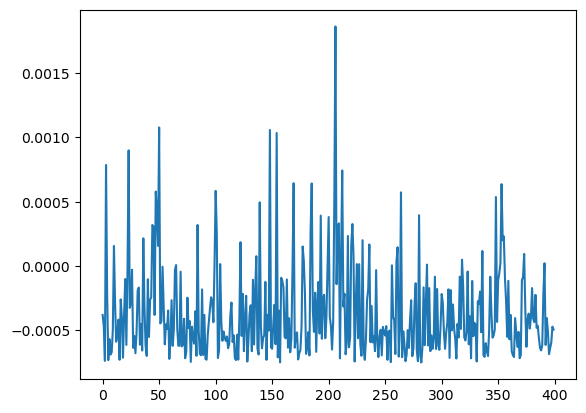

In [13]:
plt.plot(power[int(f_ind-200):int(f_ind+200)])

[[283.36758]]
[[34.97444]]


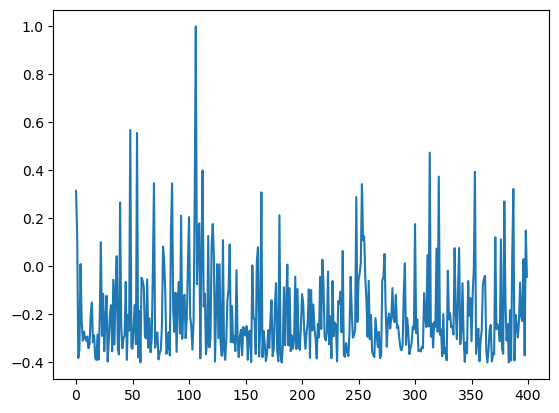

In [22]:
chunk = power[int(f_ind-100):int(f_ind+300)]
chunk = chunk/np.max(chunk)
plt.plot(chunk)
print(model_regressor_f.predict(chunk.reshape(1,400,1)))
print(model_regressor_z.predict(chunk.reshape(1,400,1)))

In [26]:
power.shape

(16777217,)

In [23]:
chunk = power[int(f_ind-400):int(f_ind+400)]
chunk = chunk/np.max(chunk)
ar = model_classifier.predict(chunk.reshape(1,800,1))

In [25]:
ar

array([[0.9924068 , 0.0011424 , 0.00272175, 0.0037291 ]], dtype=float32)

In [24]:
np.argmax(ar)

0

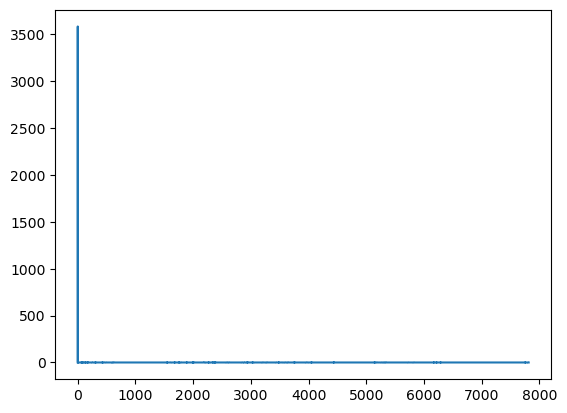

In [29]:
plt.plot(freq_axis,power)

In [45]:
regressor_chunk_start

266887

In [38]:
(f_ind - freq_ind_start)/800

89.59428395200294

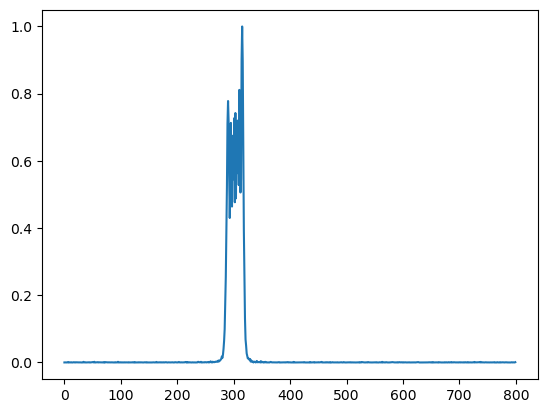

In [36]:
chunk_f = (power[124300:124300+800]/np.max(power[124300:124300+800])).reshape((1,800,1)).astype(np.float64)
plt.plot(chunk_f[0])

In [37]:
model_classifier.predict(chunk_f).argmax(axis=1)

array([1])

In [21]:
snrs = np.random.uniform(0.001,0.3,10000)

In [22]:
snrs[snrs<0.01].shape

(294,)

In [24]:
import pandas as pd

In [25]:
labels_df = pd.read_csv('meta_data/labels_runBC.csv')

In [28]:
snr_new = np.random.uniform(0.001,0.01,1000)

In [29]:
snr_new

array([0.00958479, 0.00209409, 0.00512283, 0.00795875, 0.00301289,
       0.00979674, 0.00548086, 0.00318496, 0.00187665, 0.00650367,
       0.00983793, 0.0038155 , 0.00488286, 0.00567692, 0.00655681,
       0.00813039, 0.00595487, 0.00843354, 0.00761827, 0.00823743,
       0.00166722, 0.00570765, 0.00348583, 0.00804477, 0.00841082,
       0.00478594, 0.00720284, 0.00737655, 0.00929945, 0.00866563,
       0.00394333, 0.00827038, 0.00422113, 0.00294727, 0.00603288,
       0.00120064, 0.00433821, 0.00131891, 0.00787187, 0.00965879,
       0.00524739, 0.00435194, 0.00870002, 0.00786966, 0.00719923,
       0.00321068, 0.00929521, 0.00638403, 0.00182593, 0.00952511,
       0.00571973, 0.00389952, 0.00605335, 0.00725029, 0.00750526,
       0.00751965, 0.00153224, 0.00794862, 0.00688927, 0.00863464,
       0.00619825, 0.00211758, 0.00356088, 0.00368889, 0.00825703,
       0.00480942, 0.00782101, 0.00224535, 0.00121015, 0.00868702,
       0.00459876, 0.00808844, 0.00443469, 0.00416017, 0.00705

In [30]:
labels_df['snr'][9000:] = snr_new

/tmp/ipykernel_109107/3790898055.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_df['snr'][9000:] = snr_new


In [34]:
labels_df

,period,snr,width,bper,binc,bcmass,bphase,z,# ind
0,0.004963,0.084762,11.911100,3.899263,58.517681,1.105296,0.410171,-49.354713,0
1,0.004484,0.258950,11.435892,5.562145,81.167122,1.058633,0.337352,-49.506432,1
2,0.005714,0.096731,24.854923,4.234590,84.266563,0.806586,0.284539,-49.457752,2
3,0.005220,0.047132,22.338499,4.103809,74.751907,0.727284,0.318517,-49.512989,3
4,0.007977,0.024191,17.529886,3.330099,54.897659,1.175840,0.244681,-49.917084,4
...,...,...,...,...,...,...,...,...,...
9995,0.006786,0.005473,17.874699,3.005983,80.471306,0.705039,0.885702,49.976505,9995
9996,0.008117,0.004396,18.455416,3.772956,83.339203,1.124357,0.748016,49.816051,9996
9997,0.001104,0.005850,19.211615,13.042443,52.713699,0.972458,0.819785,49.340603,9997
9998,0.001930,0.005285,17.229296,10.462254,85.428329,0.944561,0.760482,49.726585,9998
